In [38]:
import pandas as pd
import os
import json

from itertools import count
from urllib.parse import urlparse
from datetime import datetime

def read_data():
    with open("../keywords.json", "r") as fd:
        keywords = [x["keyword"] for x in json.load(fd)]
    
    return pd.DataFrame(map(get_keyword_data, keywords))

def get_keyword_data(keyword):
    before = read_result(keyword, min)
    after = read_result(keyword, max)
    
    return {
        "keyword": keyword,
        "after": get_best_ranking(after["results"]),
        "before": get_best_ranking(before["results"]),
        "after_time": after["datetime"],
        "before_time": before["datetime"],
    }

def get_best_ranking(results, domain="serlo.org"):
    for (index, entry), c in zip(enumerate(results), count(1)):
        if get_domain(entry["link"]) == domain:
            #return entry["page"]*10 + entry["index"] + 1
            return c

    return None 

def read_result(keyword, select_func):
    keyword_dir = get_keyword_dir(keyword)
    
    if not os.path.isdir(keyword_dir):
        return None
    
    to_datetime = lambda x: datetime.fromisoformat(os.path.splitext(x)[0])
    
    file_name = select_func(os.listdir(keyword_dir), key=to_datetime)
    
    with open(os.path.join(keyword_dir, file_name), "r") as fd:
        return { "results": json.load(fd), "datetime": to_datetime(file_name) }

def get_keyword_dir(keyword):
    root_dir = os.path.dirname(os.getcwd())
    return os.path.join(root_dir, "results", keyword[0], keyword)


def get_domain(url):
    parts = urlparse(url).hostname.split(".")
    domain = ".".join(parts[-2:])
    
    if domain == "wikibooks.org" and ("Freaks" in url or "Serlo" in url):
        return "serlo.org"
    else:
        return domain

df = read_data()
df.dropna(inplace=True)
df.head()

,keyword,after,before,after_time,before_time
0,addition,3.0,2.0,2021-03-09 23:17:41.383919,2021-02-11 14:31:26.890272
1,binomische formeln,15.0,15.0,2021-02-17 15:28:19.760555,2021-02-17 15:28:19.760555
2,ergebnismenge,2.0,2.0,2021-02-26 22:57:17.016432,2021-02-12 13:55:29.589465
3,relative häufigkeit,3.0,3.0,2021-02-17 13:26:24.540772,2021-02-17 13:26:24.540772
4,ereignis,10.0,10.0,2021-02-11 13:39:22.500032,2021-02-11 13:39:22.500032


In [39]:
df["diff"] = df["before"]-df["after"]
df["diff"].describe()

count    1166.000000
mean       -0.228130
std         2.793819
min       -24.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        21.000000
Name: diff, dtype: float64

<AxesSubplot:ylabel='Frequency'>

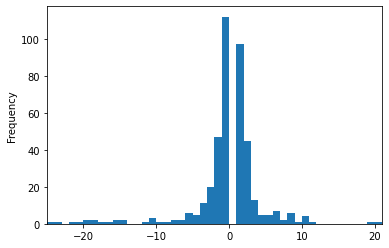

In [27]:
diffs = df["diff"][df["diff"] != 0]
diffs.plot.hist(xlim=(diffs.min(), diffs.max()), bins = int(diffs.max() - diffs.min()))

In [42]:
pd.set_option('display.max_rows', None)
df[df["diff"] > 0].describe()

,after,before,diff
count,184.000000,184.000000,184.000000
mean,9.141304,11.641304,2.500000
std,8.968167,10.216328,2.765913
min,1.000000,2.000000,1.000000
25%,3.000000,4.000000,1.000000
50%,6.000000,8.000000,1.000000
75%,12.000000,16.000000,3.000000
max,42.000000,45.000000,21.000000


In [41]:
pd.set_option('display.max_rows', None)
df[df["diff"] < 0].describe()

,after,before,diff
count,232.000000,232.000000,232.000000
mean,12.323276,9.193966,-3.129310
std,11.267844,8.918649,4.330562
min,2.000000,1.000000,-24.000000
25%,4.000000,3.000000,-3.000000
50%,8.000000,6.000000,-1.000000
75%,16.250000,12.000000,-1.000000
max,50.000000,46.000000,-1.000000
